## Music Genre Classification - GTZAN 

name: Liav Avitan

Dataset:https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



image made by Midjourney Application

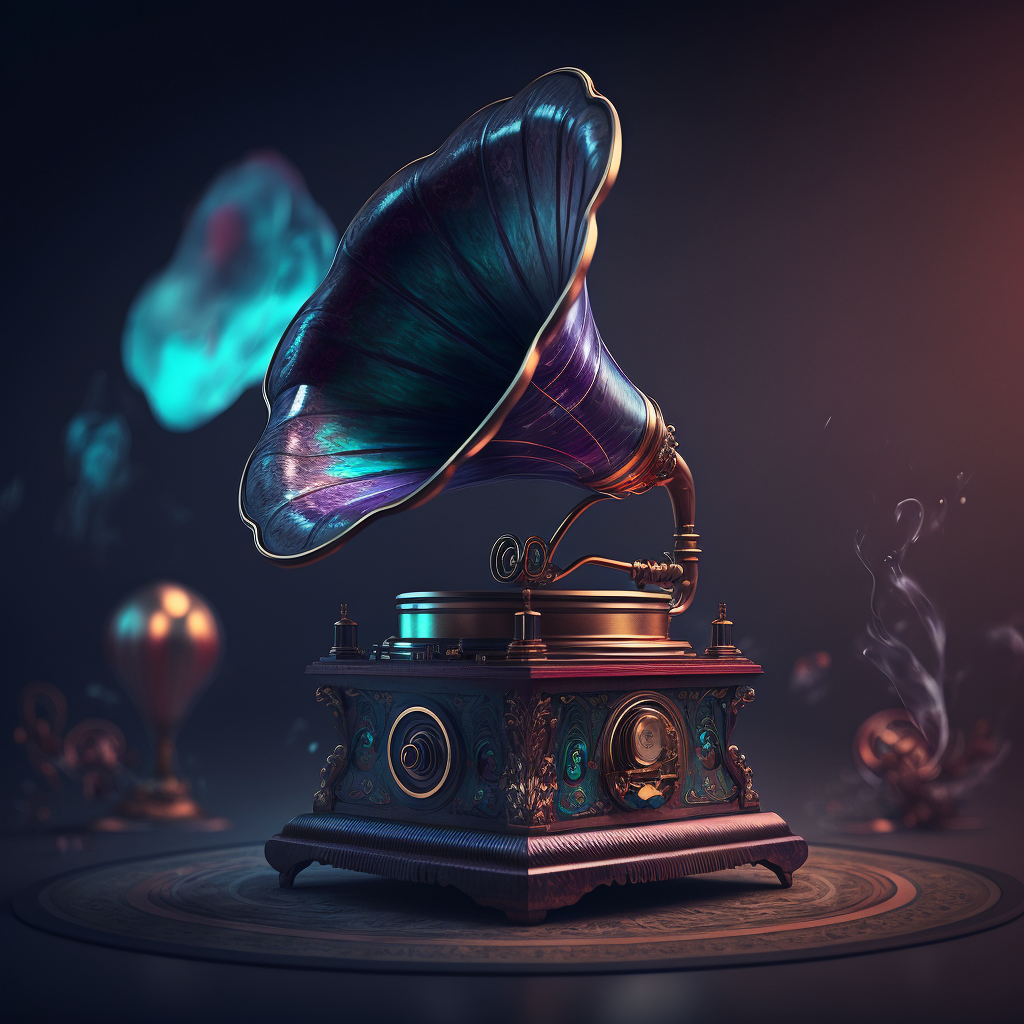

# About the data

### GTZAN:
This GTZAN Music Genre Dataset contains 1,000 song samplesbelonging to a total of 10 conventional music genres. The samples are classified into blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, and rock.  each genre contains 100 songs. In the GTZAN dataset, each song is 30 s long, with a 22,050 Hz sample rate, mono mode, .wav file format, and 16-bit audio files.

The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recordings, in order to represent a variety of recording conditions

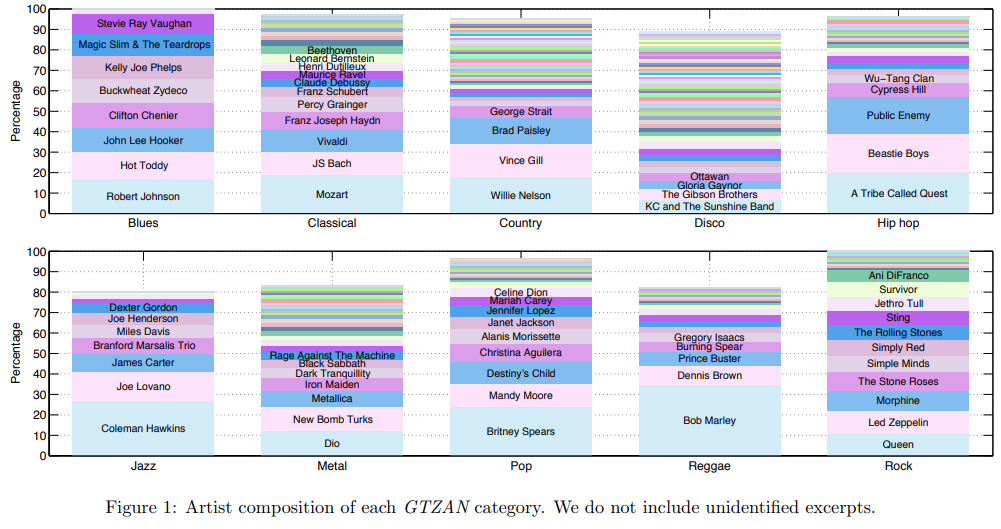

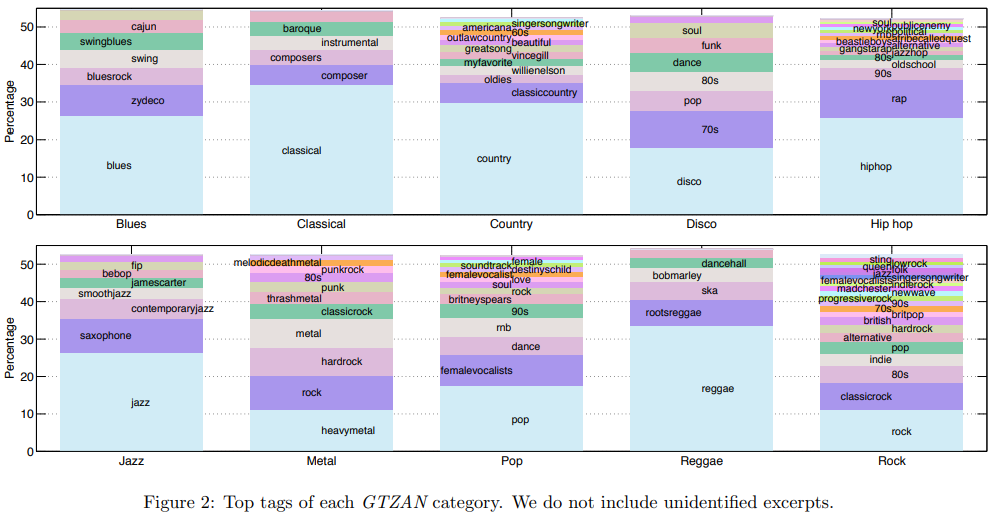

# Import data

## Install&Import

ייבוא של ספריות שנצטרך בהמשך

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install pydub
!pip install gradio
!pip install resampy
!pip install scipy
clear_output(wait=False) #clears cell output

In [ ]:
from pydub import *
import os
import resampy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

import numpy as np

import gradio as gr
from timeit import default_timer as timer

## Work with the data & Data visualization

In [ ]:
%ls

drive/  sample_data/


חיבור לדרייב

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Getting Genres from folder name
MUSIC = '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original'
music_dataset = [] #List of File locations for each wav file 
genre_target = [] # List of Genres Names
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[9])

In [ ]:
print(set(genre_target))

{'rock', 'hiphop', 'disco', 'pop', 'jazz', 'blues', 'reggae', 'classical', 'country', 'metal'}


In [ ]:
print(set(music_dataset))

{'/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/reggae/reggae.00029.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00053.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/blues/blues.00070.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00077.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/rock/rock.00002.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/rock/rock.00037.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/metal/metal.00023.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/disco/disco.00080.wav', '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/disco/disco.00040.wav', '/content/drive/MyDrive/ColabNote

In [ ]:
# Testing Audio Files

audio_path = music_dataset[499]

x , sr = librosa.load(audio_path)

librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

In [ ]:
print(music_dataset[499])

/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/reggae/reggae.00003.wav


יצירת Waveplot 


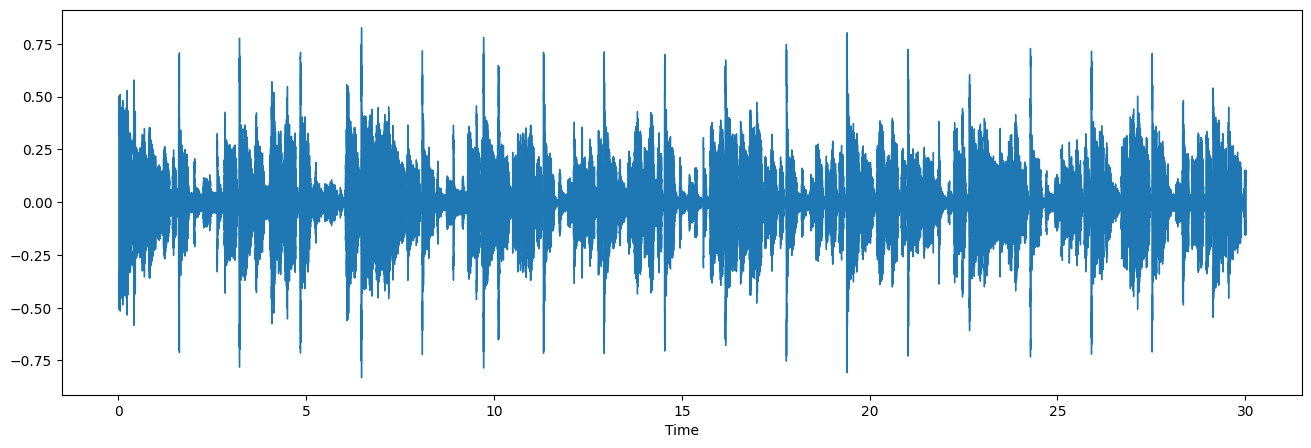

In [ ]:
plt.figure(figsize=(16, 5))
librosa.display.waveshow(x, sr=sr)

ייצוג גרפית של איך נראה שיר בספקטוגרמה

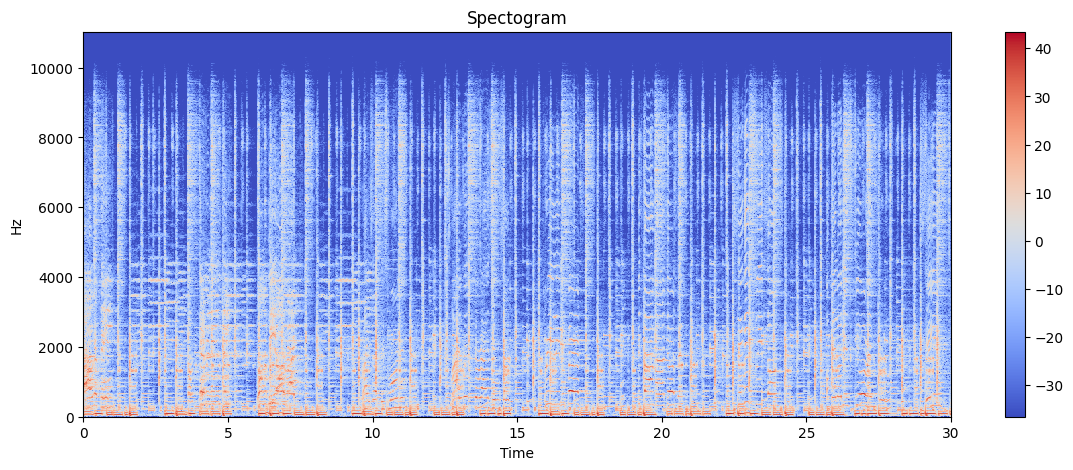

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

ייצוג של איך נראה שיר בתור מל ספקטוגרמה

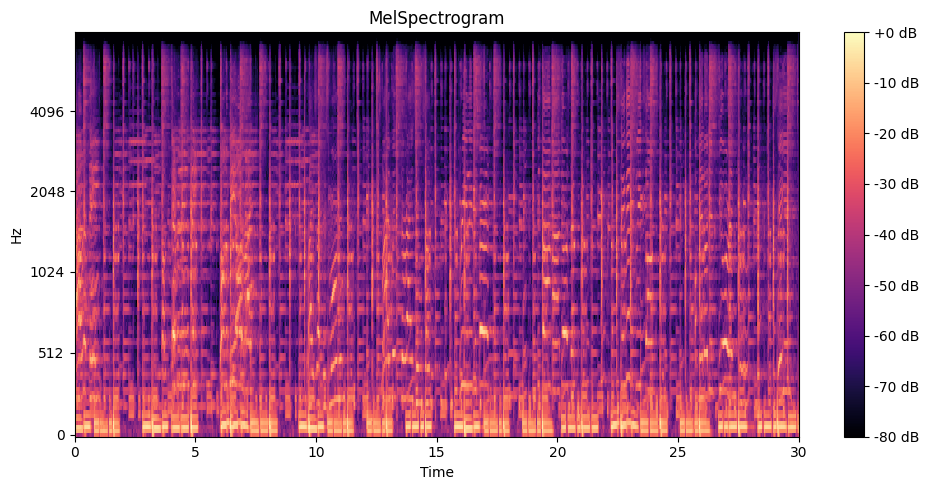

In [ ]:
file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

# Data preparation (Preprocessing)


הכנת הדאטא: כמה שלבים שאנחנו עושים - 
1. מחלקים את המידע - כל שיר מחולק ל6 חלקים/רצפים
2. עוברים על הדאטא סאט, שומרים את הז'אנרים הקיימים, ואת כמות הדגימות שלקחנו
3. MFCCבנוסף שומרים את ה 
4. Json שומרים הכל בקובץ 



In [ ]:
DATASET_PATH = '' #data set destination
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050 #each song is 30s long, with a 22,050 Hz sample rate
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION #=661,500


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract. refers to the accuracy, 13 is a traditional number
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [], #label names. size - (10,)
        "labels": [],  #Stores the 'real' song type(value from 0-9). size - (5992,)
        "mfcc": []     #store the mfccs.size - (5992, 216, 13)
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)  #=110250
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length) #=216(math.ceil of 215.332)
    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

      # ensure we're processing a genre sub-folder level
      if dirpath is not dataset_path:

          # save genre label (i.e., sub-folder name) in the mapping
          semantic_label = dirpath.split("/")[-1]
          data["mapping"].append(semantic_label)
          print("\nProcessing: {}".format(semantic_label))
          # process all audio files in genre sub-dir
          for f in filenames:

            # load audio file

            file_path = os.path.join(dirpath, f)
        
            if file_path != '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00054.wav': 
              """fileError: Error opening '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00054.wav': File contains data in an unknown format."""

              signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) 

              # process all segments of audio file
              for d in range(num_segments):

                # calculate start and finish sample for current segment
                start = samples_per_segment * d
                finish = start + samples_per_segment

                # extract mfcc
                mfcc = librosa.feature.mfcc(y=signal[start:finish],sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length) #mfcc - time and Coef(13 because num_mfcc=13), 
                mfcc = mfcc.T #[216,13]
                # store only mfcc feature with expected number of vectors
                if len(mfcc) == num_mfcc_vectors_per_segment: #==216
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i-1)
                    print("{}, segment:{}".format(file_path, d+1))
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4) #puts everything in the Json File

In [ ]:
# Runs Data Processing    
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00064.wav, segment:1
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00064.wav, segment:2
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00064.wav, segment:3
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00064.wav, segment:4
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00064.wav, segment:5
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00064.wav, segment:6
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00059.wav, segment:1
/content/drive/MyDrive/ColabNotebooksNew/PROJECT/ProjectMusic/Data/genres_original/jazz/jazz.00059.wav, segment:2
/content/drive/MyDrive/ColabNotebooks

# Model preparation and training 

כאן אנו מגדירים כמה פונקציות, בין אם לטעון את המידע מן הקובץ ולשמור הכל, לחלק את הדאטאסט לפי אחוז לאימון, טסט ועוד, בניית המודל, ופונקציה של חיזוי הז'אנר

In [ ]:
#DATA_PATH = "./data_10.json"
DATA_PATH = "" #preprocessed data path

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    #the data is in order - from 1st genre(Y=0) to 10th genre(Y=9)
    X = np.array(data["mfcc"])   #mfccs
    y = np.array(data["labels"]) #genre type for each _____(the Y)
    z = np.array(data['mapping']) #num of genres
    return X, y, z


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    :return z : Mappings for data
    """

    # load data
    X, y, z = load_data(DATA_PATH)
    
    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape): #(216,13,1)
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
    
    # build network topology
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(32, (3, 2), activation='relu',input_shape=input_shape,kernel_regularizer=tf.keras.regularizers.L1L2(0.01)))
  
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64, (3, 2), activation='relu'))
    
    model.add(keras.layers.MaxPooling2D((3, 2),strides=(2,1)))

    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64, (3, 2), activation='relu'))

    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(128, (3, 2), activation='relu')) 
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.MaxPooling2D((3, 2)))
    # flatten output and feed it into dense layer
    model.add(keras.layers.GlobalAveragePooling2D())
    
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 216, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

נחלק את הנתונים למקבצים שונים - אימון,ולידציה,טסט

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.1, 0.1) #10% Test set, 10% Validation Set, 80% Training Set

Creating The CNN model

Preparing the data

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1) #(216,13,1)
model = build_model(input_shape)

שלב הלמידה

In [ ]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,verbose=1) #patience=stop after 8 epochs without improvement(on vall loss)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,patience=4, verbose=1, mode='auto')

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=150, verbose=1,callbacks=[earlystopping, reduceLR])

duration = datetime.now()

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print("Training completed in time:", duration)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 214, 12, 32)       224       
                                                                 
 batch_normalization_24 (Bat  (None, 214, 12, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 212, 11, 64)       12352     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 105, 10, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 105, 10, 64)      256       
 chNormalization)                                                
                                                      

הצגת המודל ויזואלית

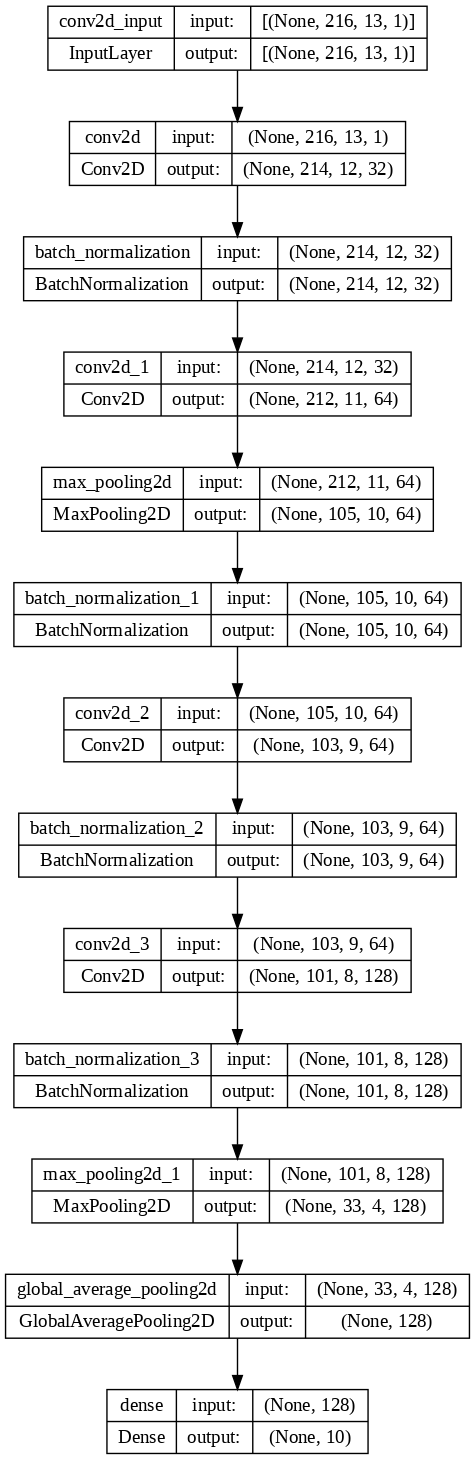

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

גרפים של הלמידה

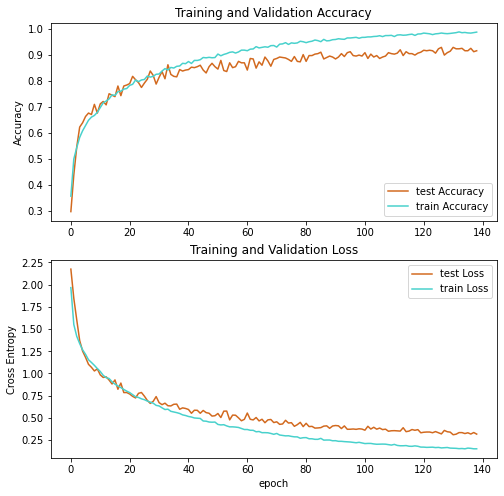

In [ ]:
# plot accuracy/error for training and validation
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(test_acc,color='chocolate', label='test Accuracy')
plt.plot(acc,color='mediumturquoise', label='train Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(test_loss,color='chocolate', label='test Loss')
plt.plot(loss,color='mediumturquoise', label='train Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

שמירה/טעינת המודל

In [ ]:
model.save_weights('') #save weights

In [ ]:
model.load_weights('') #load weights

# Visualization

In [ ]:
X, y, z = load_data(DATA_PATH)

In [ ]:
print(X.shape,'\n',y.shape,'\n',z.shape)


(5992, 216, 13) 
 (5992,) 
 (10,)


MFCCנראה את הערכים של המקדמים של ה

In [ ]:
print(X[0]) 

[[-151.17372131  102.47348022    3.08465576 ...  -17.18112373
     3.23825383  -13.32950783]
 [-115.99925995  110.66014099   12.00667572 ...  -15.05039501
     7.01292276  -16.17678833]
 [-137.8444519   119.91876984   19.13338089 ...   -9.61055851
    10.18940544  -17.724123  ]
 ...
 [-169.20233154  104.53716278   -4.56687498 ...   -2.03475285
    -3.41015172  -12.35482597]
 [-180.43540955  120.17881775   -7.6565733  ...   -2.66935587
    -3.94964838  -11.22442627]
 [-188.11303711  121.79550171    1.20221937 ...    4.02285862
    -3.84977698   -5.90188599]]


איך נראת דוגמא בצורה ויזואלית 

<function matplotlib.pyplot.show(close=None, block=None)>

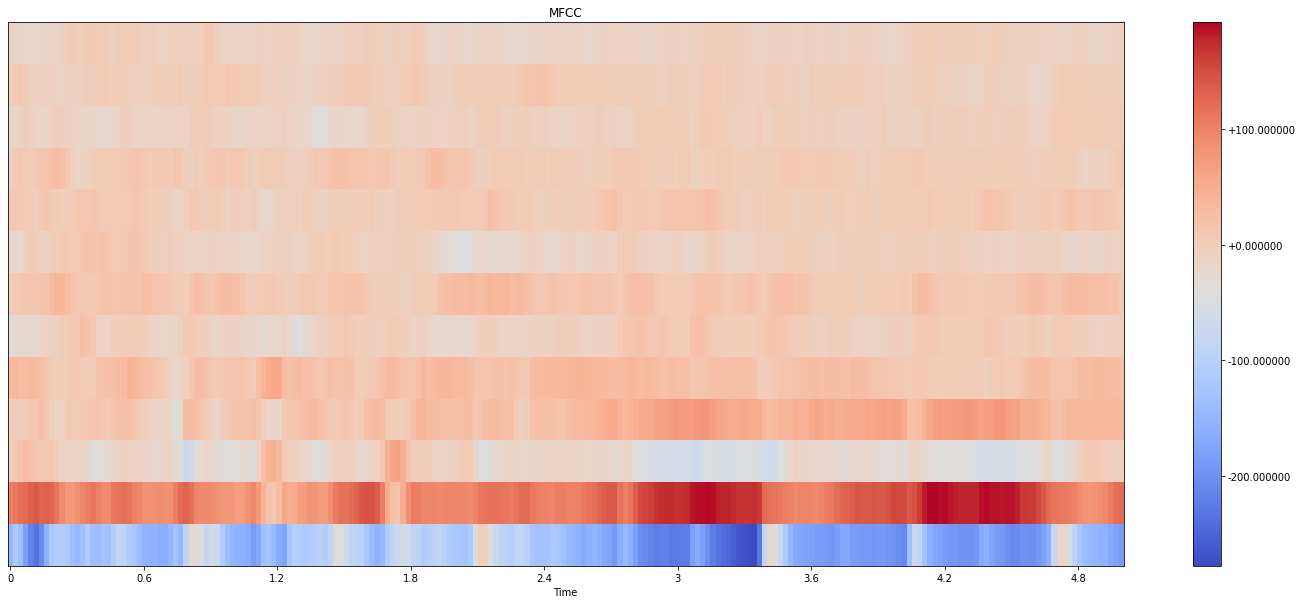

In [ ]:
plt.figure(figsize=(25,10))
plt.title('MFCC')
librosa.display.specshow(X[0].T,x_axis="time",sr=22050)
plt.colorbar(format="%+2f")
plt.show

נחזה לדוגמא שיר מתוך המאגר

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[153]
y_to_predict = y_test[153]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 48ms/step
Target: country, Predicted label: ['country']


In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_pred[:10]

19/19 [==============================] - 1s 15ms/step


array([6, 3, 3, 0, 3, 4, 1, 3, 5, 8])

Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test,y_pred = y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9737    0.9867    0.9801        75
           1     0.9861    1.0000    0.9930        71
           2     1.0000    0.9701    0.9848        67
           3     0.9811    1.0000    0.9905        52
           4     0.9672    0.9672    0.9672        61
           5     0.9804    0.9615    0.9709        52
           6     0.9804    0.9615    0.9709        52
           7     0.9796    0.9796    0.9796        49
           8     0.9821    0.9821    0.9821        56
           9     0.9848    1.0000    0.9924        65

    accuracy                         0.9817       600
   macro avg     0.9816    0.9809    0.9812       600
weighted avg     0.9817    0.9817    0.9816       600



Confusion matrix

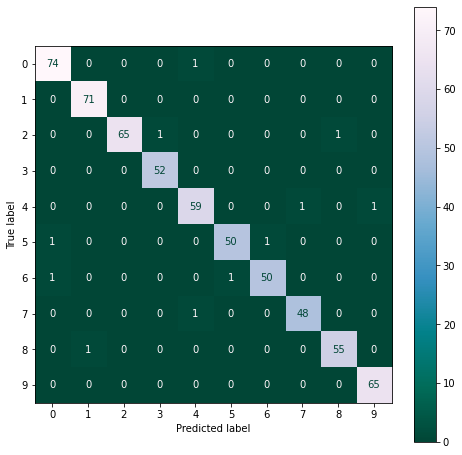

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred,cmap=plt.cm.PuBuGn_r, ax=ax);

# New Song Classify

## Functions

In [ ]:
def convert_to_wav(src):
  '''Converts mp3 file to wav
        :param src (str): Path to mp3 file containing the song
        :return src+name (str): return path to the wav file
  '''
  audio = AudioSegment.from_mp3(src)
  path = src.split("/")
  src, name = "/".join(path[:-1]), path[-1][:path[-1].find(".")]+".wav"

  audio.export(src + name, format="wav")
  return src + name

def getData(path):
  '''Converts the song to Wav(Uses Convert_to_wav Function), gets data about the song with the desired SampleRate
      :param path (str): Path to mp3 file containing the song
      :return signal,sr,Duration,num_segments (int): return data about the Song
  '''
  Song = path
  Song = convert_to_wav(Song)
  
  Duration=math.floor(librosa.get_duration(filename=Song))
  print(Duration)

  signal , sr = librosa.load(Song)
  resampy.resample(signal, sr, 22050)

  num_segments=math.floor(Duration/5)
  print(num_segments)

  return signal,sr,Duration,num_segments



def mfcc(signal, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5,samples_per_segment=110250): 
  """Return dictionary with the MFCCs of the Song 
      :param model: signal(the data)
  """
  # samples_per_segment=110250 because we used it in last preprocessing data 
  
  data = {
  "mfcc": []     #store the mfccs.size - (5992, 216, 13)
  }

  for i in range (num_segments):
    start = samples_per_segment * i
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish],sr=sr, n_mfcc=13, n_fft=2048, hop_length=512) #mfcc - time and Coef(13 because num_mfcc=13), 
    mfcc = mfcc.T #[216,13]

    if len(mfcc) == 216: #==216
        data["mfcc"].append(mfcc.tolist())

  X = np.array(data["mfcc"])   #mfccs as numpy array
  return X

def predictSeg(model, X):
    """Predict a single Segment using the trained model
    :param model: Trained classifier
    :param X: Input data
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    predicted = z[predicted_index]

    print("Predicted label: {}".format(predicted))

    return str(predicted)

def predictSong(model,Seg):
  '''predicts the segments of the song by using trained model(by using predictSeg function) and converting it into a list
    :param model: Trained classifier
    :param Seg (numpy array): contains all of the song segments divided. size - (23,216,13,1)
    :return l(list): which stores list of all of the segments genre predictions. 
  '''
  l = []
  for i in range(Seg.shape[0]):

    genre = predictSeg(model, Seg[i])

    l.append(genre)

  return l

def genrePercentage(model,Seg):
  '''prints the genre percentage prediction, and returns str list of percentage of all genre predictions and dictionary with genre predictions as decimal(Using predictSong function).
  :param model: Trained classifier
  :param percentage(list): list which contains str with genre and its percentage in predictions
  :return dict1(dict): dictionary of genre predictions in relation to all predictions as decimal(100%-->1,50%-->0.5)
  '''
  genres = ['reggae', 'country', 'pop', 'hiphop', 'rock', 'classical', 'jazz', 'blues', 'disco', 'metal']
  percentage = []

  dict1 = {} #creates a dictionary

  list1 = predictSong(model,Seg)
  list1 = ' '.join(list1).replace("['",'').split() 
  list1 = ' '.join(list1).replace("']",'').split()
  #remove the brackets from list1

  total = len(list1)

  for i in range (10):
    # print predicted label and it percentage for all genres, save it in 'percentage' list, save dict1 predictions 
    print("Predicted label: {}, percentage: {}".format(genres[i],str(round(list1.count(genres[i])/total*100,2))+"%"))
    percentage.append("Predicted label:"+str(genres[i])+" ,percentage:"+str(round(list1.count(genres[i])/total*100,2))+"%")
    dict1[genres[i]] = round(list1.count(genres[i])/total,3)
                         
  return percentage,dict1

## Example 

In [ ]:
Song = '/content/drive/MyDrive/ColabNotebooksNew/PROJECT/Songs/stomping-rock-four-shots-111444.mp3'
signal,sr,Duration,num_segments = getData(Song)

<ipython-input-33-328305927dee>:21: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  Duration=math.floor(librosa.get_duration(filename=Song))


119
23


In [ ]:
print(signal,sr,Duration,num_segments)

[5.4569682e-12 2.3646862e-11 1.6370905e-11 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] 22050 119 23


In [ ]:
Seg = mfcc(signal, num_segments=num_segments)

In [ ]:
Seg.shape

(23, 216, 13)

In [ ]:
Seg= Seg[...,np.newaxis] 
Seg.shape

(23, 216, 13, 1)

In [ ]:
percentage,dict1 = genrePercentage(model,Seg)

1/1 [==============================] - 0s 26ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 19ms/step
Predicted label: ['jazz']
1/1 [==============================] - 0s 32ms/step
Predicted label: ['jazz']
1/1 [==============================] - 0s 21ms/step
Predicted label: ['hiphop']
1/1 [==============================] - 0s 23ms/step
Predicted label: ['rock']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['hiphop']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['country']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['pop']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['hiphop']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['metal']
1/1 [==============================] - 0s 17ms/step
Predicted label: ['rock']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['rock']
1/1 [==============================] - 0s 18ms/ste

In [ ]:
dict1

{'classical': 0.043,
 'jazz': 0.087,
 'hiphop': 0.217,
 'rock': 0.13,
 'country': 0.217,
 'pop': 0.217,
 'metal': 0.087,
 'reggae': 0.0,
 'blues': 0.0,
 'disco': 0.0}

In [ ]:
percentage

['Predicted label:reggae ,percentage:0.0%',
 'Predicted label:country ,percentage:21.74%',
 'Predicted label:pop ,percentage:21.74%',
 'Predicted label:hiphop ,percentage:21.74%',
 'Predicted label:rock ,percentage:13.04%',
 'Predicted label:classical ,percentage:4.35%',
 'Predicted label:jazz ,percentage:8.7%',
 'Predicted label:blues ,percentage:0.0%',
 'Predicted label:disco ,percentage:0.0%',
 'Predicted label:metal ,percentage:8.7%']

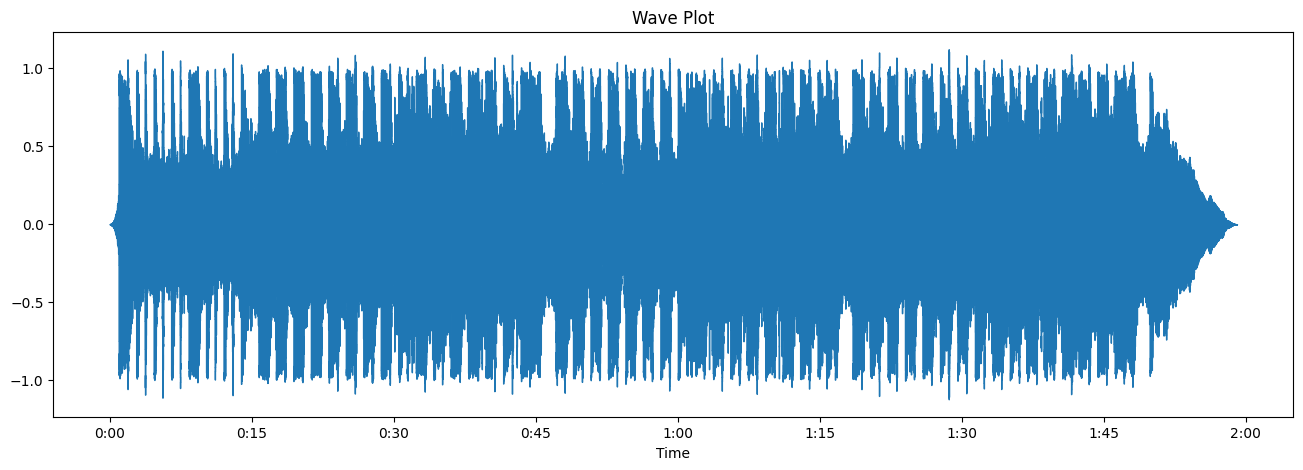

In [ ]:
plt.figure(figsize=(16, 5))
plt.title('Wave Plot')
librosa.display.waveshow(signal, sr=sr)

## יישום

In [ ]:
def getPath(src):
  '''
  Get the path for the song
  inp: Str
  Returns: Str 
  '''
  src = src.replace("-0-100", "")
  return src

def save(signal,sr):
  '''
  Save the Waveform and the MelSpectogram into google drive. 
  inp: int,int
  Returns: 
  '''
  melSpec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
  melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
  plt.figure(figsize=(10, 5))
  img = librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
  plt.colorbar(format='%+1.0f dB')
  plt.tight_layout()
  #plt.title('Mel Spectogram')
  plt.savefig("MelSpectogram.png")

  plt.figure(figsize=(16, 5))
  img = librosa.display.waveshow(signal, sr=sr)
  #plt.title('Wave Plot')
  plt.savefig("waveplot.png")

/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `capture_session` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/interface.py:333: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9e39dbe1fc2d3bf96d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


<ipython-input-33-328305927dee>:21: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  Duration=math.floor(librosa.get_duration(filename=Song))


122
24
1/1 [==============================] - 0s 19ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 17ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 17ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 20ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 20ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 20ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 24ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 17ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 17ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 18ms/step
Predicted label: ['classical']
1/1 [==============================] - 0s 16ms/step
Predicted label: ['classical

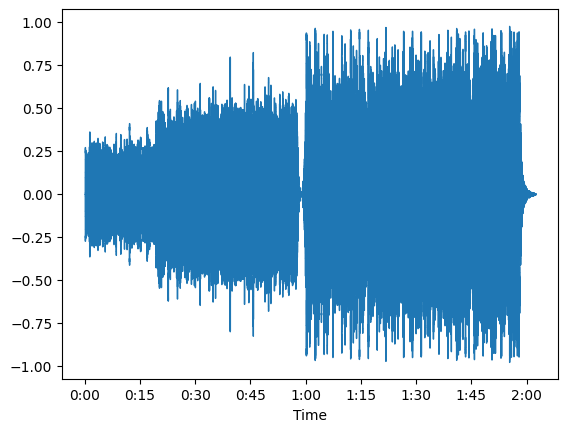

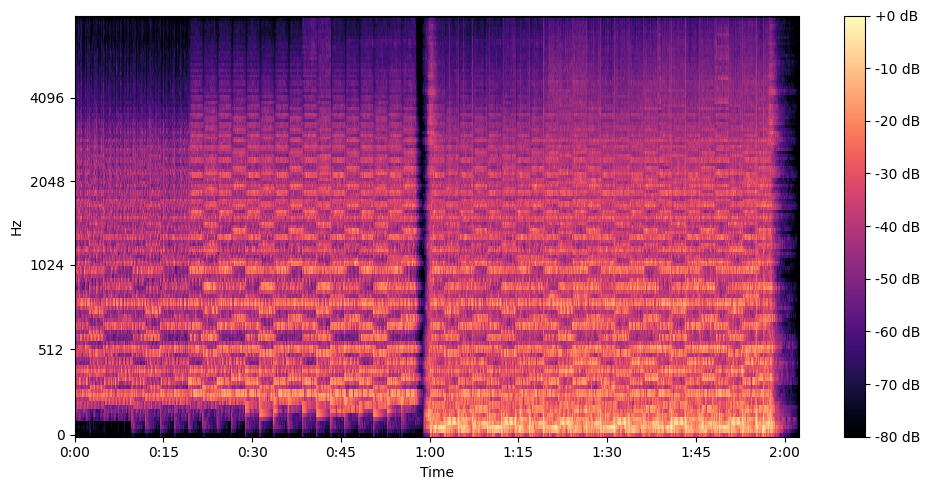

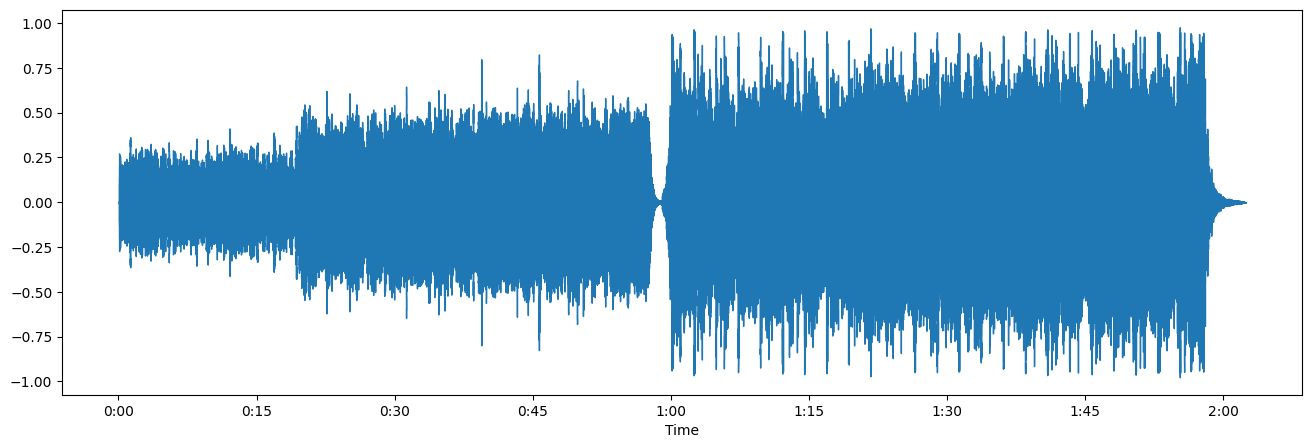

In [ ]:
#Path = /tmp/d681ea5f74f4705b36be19d1b67e6a23e8812dcf/Tuyo ringtone.mp3

title = "Classify"
description="Hello there! Welcome to Classify made by Liav. Please add your song and wait to your song to be predicted which genre it is in!"

def Genre(Source):
  '''
  inp: Audio File
  Returns: str
  '''
  start_time = timer()

  path = getPath(Source) #gets the path without -0-100

  signal,sr,Duration,num_segments = getData(path)

  inpSeg = mfcc(signal, num_segments=num_segments)

  inpSeg= inpSeg[...,np.newaxis] #add 1 dimension for predictions
  
  pred_time = round(timer() - start_time, 5)

  percentage,dict1 = genrePercentage(model,inpSeg)
  
  save(signal,sr) 

  path1 = '/content/waveplot.png'
  path2 = '/content/MelSpectogram.png'

  return dict1,pred_time,path1,path2

demo = gr.Interface(
    fn=Genre,
    inputs=gr.Audio(type="filepath"),
    outputs=[gr.Label(num_top_classes=10,label="Prediction"),gr.Number(label="Prediction time"),gr.Image(label="Waveform"),gr.Image(label="MelSpectogram")],
    title=title,
    description=description,
    theme=gr.themes.Soft(),
    allow_flagging='never'
)

demo.launch(share=True, debug=True)